In [74]:
import platform
import os
import datetime
import pynvml
import psutil




def print_env():
    print('========== System Information ==========')
    # 오늘의 날짜
    current_date = datetime.date.today()
    print(f'DATE : {current_date}')
    
    # Python 버전
    python_version = platform.python_version()
    print(f'Pyton Version : {python_version}')
    
    # Pytorch 버전
    # 이 환경에 PyTorch가 설치되어 있는지 확인합니다.
    try:
        import torch
        pytorch_version = torch.__version__
        
    except ImportError:
        pytorch_version = "PyTorch not installed"

    print(f'PyTorch Version : {pytorch_version}')
    # 현재 작업환경의 os
    os_info = platform.system() + " " + platform.release()
    print(f'OS : {os_info}')
        
    # 현재 작업환경의 CPU 스펙
    cpu_info = platform.processor()
    print(f'CPU spec : {cpu_info}')
    
    # 현재 작업환경의 Memory 스펙
    mem_info = psutil.virtual_memory().total
    print(f'RAM spec : {mem_info / (1024**3):.2f} GB')
    
    # 현재 작업환경의 GPU 스펙
    pynvml.nvmlInit()

    device_count = pynvml.nvmlDeviceGetCount()
    for i in range(device_count):
        handle = pynvml.nvmlDeviceGetHandleByIndex(i)
        name = pynvml.nvmlDeviceGetName(handle)
        memory_info = pynvml.nvmlDeviceGetMemoryInfo(handle)
        driver_version = pynvml.nvmlSystemGetDriverVersion()
        
        print(f"Device {i}:")
        print(f"Name: {name}")
        print(f"Total Memory: {memory_info.total / 1024**2} MB")
        print(f"Driver Version: {driver_version}")
        print("="*30)

    pynvml.nvmlShutdown()



    
        
print_env()

========== System Information ==========
DATE : 2023-08-31
Pyton Version : 3.10.12
PyTorch Version : 2.0.1
OS : Linux 5.15.0-78-generic
CPU spec : x86_64
RAM spec : 122.84 GB
Device 0:
Name: NVIDIA GeForce RTX 3090
Total Memory: 24576.0 MB
Driver Version: 530.41.03
Device 1:
Name: NVIDIA GeForce RTX 3090
Total Memory: 24576.0 MB
Driver Version: 530.41.03


In [75]:
import os
import sys
from PIL import Image

sys.path.append('..')

In [76]:
# 데이터 경로 설정
PATH = '../data/raw'
SOURCE_PATH = os.path.join(PATH,'train_source_image')
TARGET_PATH = os.path.join(PATH,'train_target_image')
SOURCE_LIST = [os.path.join(SOURCE_PATH,x) for x in os.listdir(SOURCE_PATH)]
TARGET_LIST = [os.path.join(TARGET_PATH,x) for x in os.listdir(TARGET_PATH)]

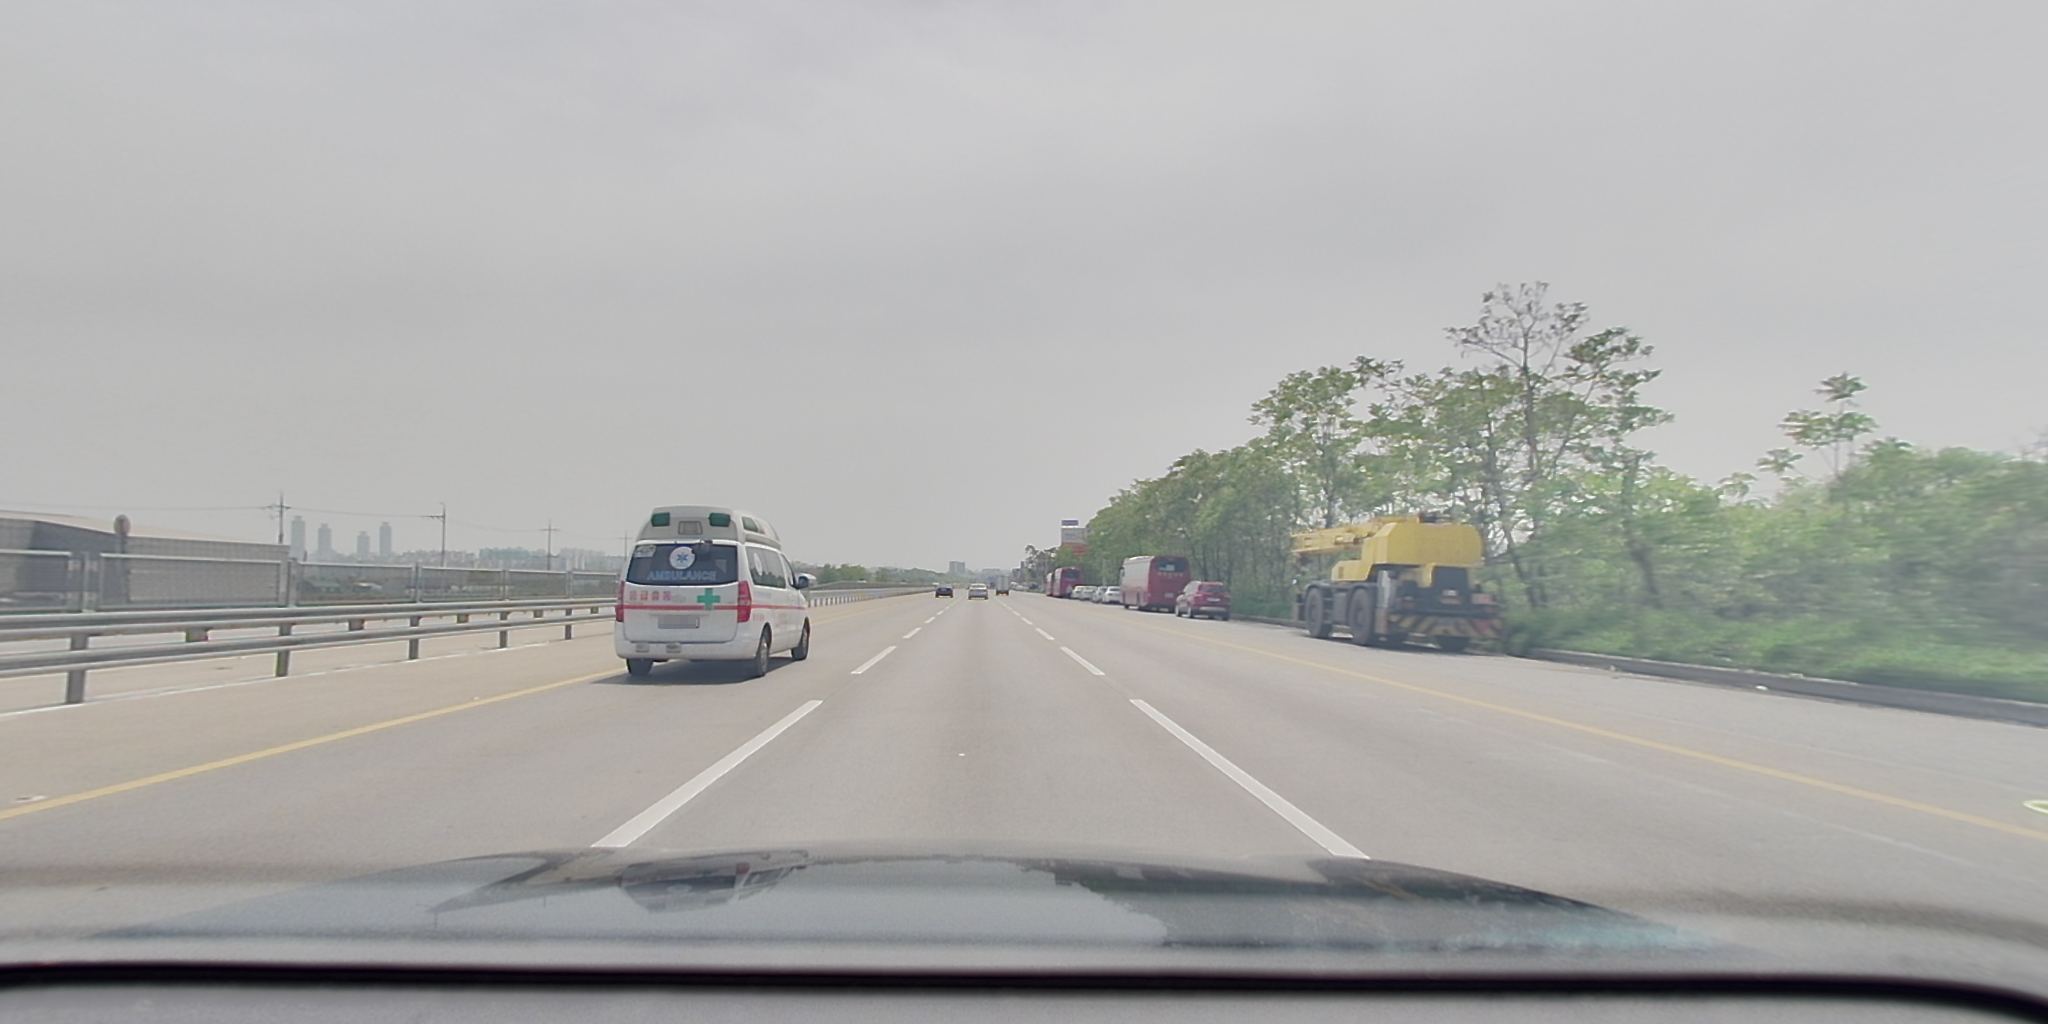

In [77]:
source_image = Image.open(SOURCE_LIST[0])
source_image

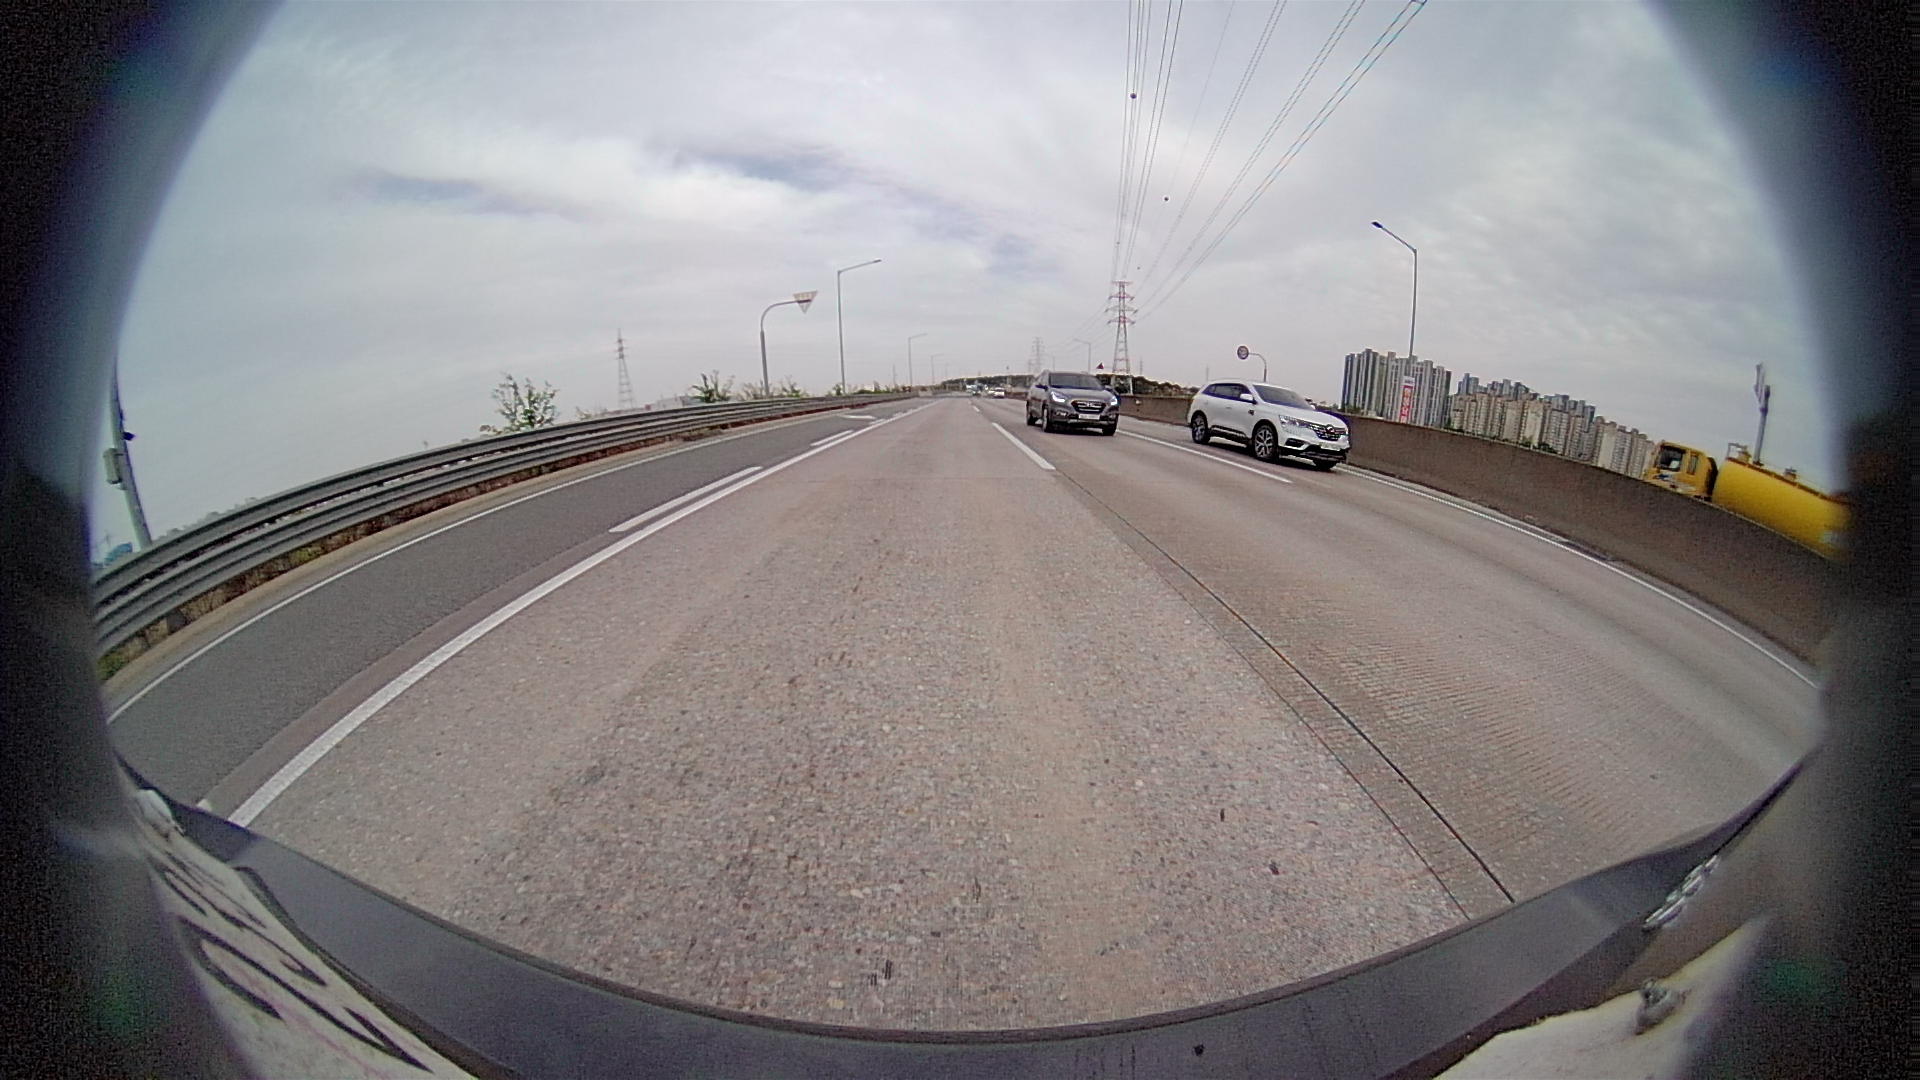

In [78]:
target_image = Image.open(TARGET_LIST[0])
target_image

# 목표
Target domain 이미지의 특성과 가장 유사한 Fisheye transfomation을 Implemenation

# Non-Linear Fisheye Transform 

(Ref: [Post by Nilesh Vijayrania](https://towardsdatascience.com/non-linear-augmentations-for-deep-leaning-4ba99baaaaca))

$$ T(x) = x + d(x - c_x)\sqrt{(x - c_x)^2 + (y - c_y) ^ 2} $$
$$ T(y) = y + d(y - c_y)\sqrt{(x - c_x)^2 + (y - c_y) ^ 2} $$
where $x \in [-1, 1], y \in [-1, 1]$, $(c_x, c_y)$ is the center of image and $d$ is a distortion factor.

## 수리적 분석

1. 기본 구조

    이 변환은 두 부분으로 구성되어 있다:

    - 원래 좌표 $(x, y)$.
    - 변환에 의한 추가 항.

2. 거리 기반 변환

    변환의 추가 항은 원점에서의 거리 $\sqrt{x^2 + y^2}$을 기반으로 한다.
    이는 점이 원점에서 얼마나 멀리 떨어져 있는지를 나타내는 값입니다.

3. distortion factor $d$
    $d$는 변환의 정도를 조절하는 스케일링 팩터다. 
    - $d>0$ 인 경우 : 점은 원점에서 더 멀리 이동하게 된다 
    - $d<0$ 인 경우 : 점은 원점으로 더 가까워 진다.

4. 수학적 통찰

    - 원점 근처의 작용: 원점 근방에서는 원점으로부터의 거리가 작기 때문에, 추가 항의 영향이 작다. 따라서 변환은 거의 없다.
    - 원점에서 멀리 떨어진 점의 작용: 점이 원점에서 멀리 떨어져 있을수록, 추가 항의 영향이 커진다. 따라서 변환은 원점으로부터 더욱 멀어지게 된다.
    - 방향성 : 변환은 점의 원래 위치에 따라 방향이 결정된다. 
    - 변환의 강도: 
    distortion 값에 따라 변환의 강도가 결정된다. 
    distortion의 값을 변경함으로써 변환의 정도를 조절할 수 있다.

결론적으로, 이 변환은 원점에서의 거리와 주어진 점의 위치에 따라 점을 이동시키는 효과를 가지며, 
distortion
distortion 값에 의해 그 정도가 조절된다.

In [79]:
import torch
import torch.nn.functional as F
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

# PIL image를 torch tensor로 변환
def get_image_tensor(img):
    transform = transforms.Compose([transforms.ToTensor()])
    img_tensor = transform(img)
    img = torch.unsqueeze(img_tensor, dim=0)
    return img

# Fisheye grid를 생성하는 함수
def fisheye_grid(height, width, center, distortion):
    """
    Fisheye transform maps a given pixel location (x,y) to (T(x), T(y)), where
    T(x) = x + (x - c_x) * d * sqrt{(x - c_x)^2 + (y-c_y)^2}
    T(y) = y + (y - c_y) * d * sqrt{(x - c_x)^2 + (y-c_y)^2}
    
        Args:
            - image (ndarray) : input image
            - center (tuple) : center of transformation. If it is None, set it as the center of the input image.
            - distortion: distortion factor d
    """
    
    xx, yy = torch.linspace(-1, 1, width), torch.linspace(-1, 1, height)
    gridy, gridx = torch.meshgrid(yy, xx)
    grid = torch.stack([gridx, gridy], dim=-1)
    diff = center - grid
    dist = torch.sqrt((diff**2).sum(axis=-1))
    grid += diff * dist.unsqueeze(-1) * distortion
    return grid.unsqueeze(0)

# 원본 이미지와 변환된 이미지를 비교
def plot(img, fisheye_output):
    fisheye_out = fisheye_output[0].numpy()
    fisheye_out = np.moveaxis(fisheye_out, 0, -1)
    
    fig, ax = plt.subplots(1, 2, figsize = (16,4))
    ax[0].imshow(img)
    ax[1].imshow(fisheye_out)
    
    plt.show()

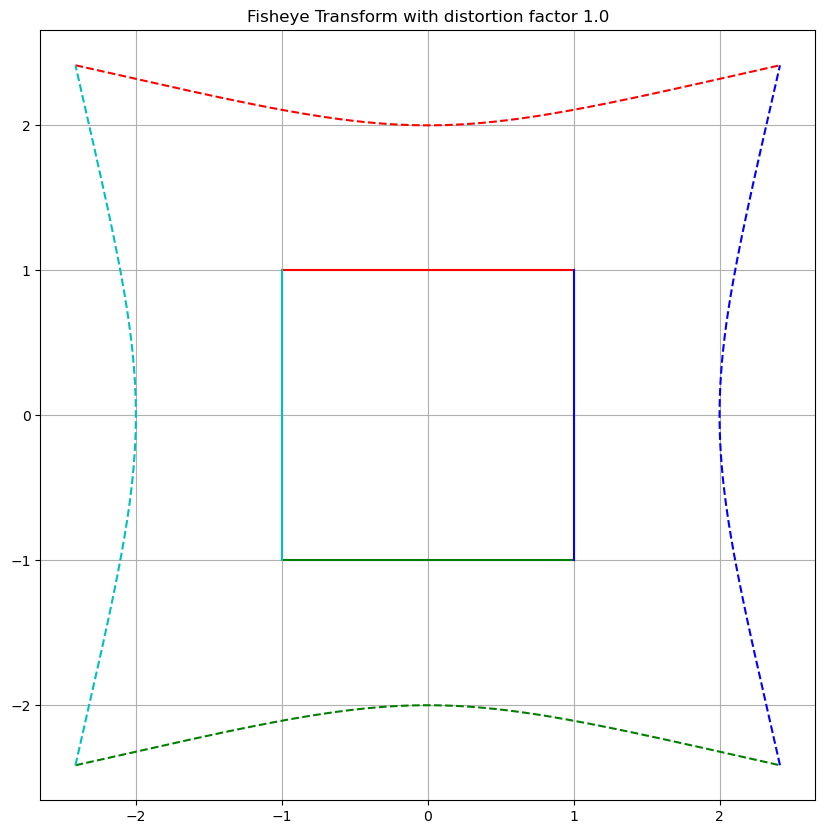

In [80]:
# Transform 분석
"""
좌표평면 위의 정 사각형이 T에 의해 어떻게 변환되는지 보면서 T의 특징을 살펴보자.
"""

# Unit square
x1 = np.linspace(-1, 1, 1000)
y1 = np.array([1]*1000)

x2 = np.linspace(-1, 1, 1000)
y2 = np.array([-1]*1000)

x3 = np.array([1]*1000)
y3 = np.linspace(-1, 1, 1000)

x4 = np.array([-1]*1000)
y4 = np.linspace(-1, 1, 1000)

# Transformed
def TxTy(x,y,distortion):
    Tx = x + (x-0)*distortion*np.sqrt(x**2 + y**2)
    Ty = y + (y-0)*distortion*np.sqrt(x**2 + y**2)
    return Tx, Ty

distortion = 1.0

Tx1, Ty1 = TxTy(x1, y1, distortion)
Tx2, Ty2 = TxTy(x2, y2, distortion)
Tx3, Ty3 = TxTy(x3, y3, distortion)
Tx4, Ty4 = TxTy(x4, y4, distortion)

plt.figure(figsize=(10,10))
plt.title(f'Fisheye Transform with distortion factor {distortion}')


plt.plot(x1, y1, '-r')
plt.plot(Tx1, Ty1, '--r')

plt.plot(x2, y2, '-g')
plt.plot(Tx2, Ty2, '--g')

plt.plot(x3, y3, '-b')
plt.plot(Tx3, Ty3, '--b')

plt.plot(x4, y4, '-c')
plt.plot(Tx4, Ty4, '--c')

plt.grid()


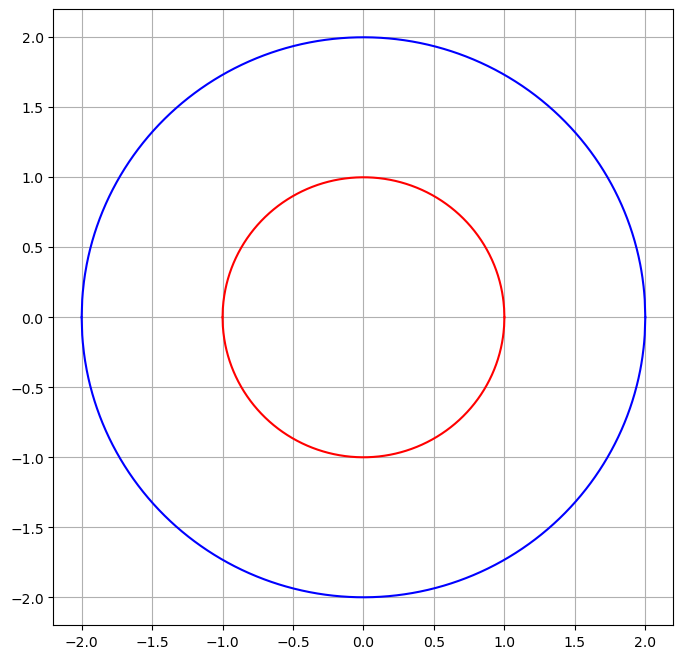

In [81]:
x = np.linspace(-1, 1, 1000)
yup = np.sqrt(1 - x**2)
ydown = -yup

Tx, Tyup = TxTy(x, yup, distortion)
Tx, Tydown = TxTy(x, ydown, distortion)

plt.figure(figsize=(8,8))
plt.plot(x,yup, '-r')
plt.plot(x,ydown, '-r')
plt.plot(Tx, Tyup, '-b')
plt.plot(Tx, Tydown, '-b')

plt.grid()

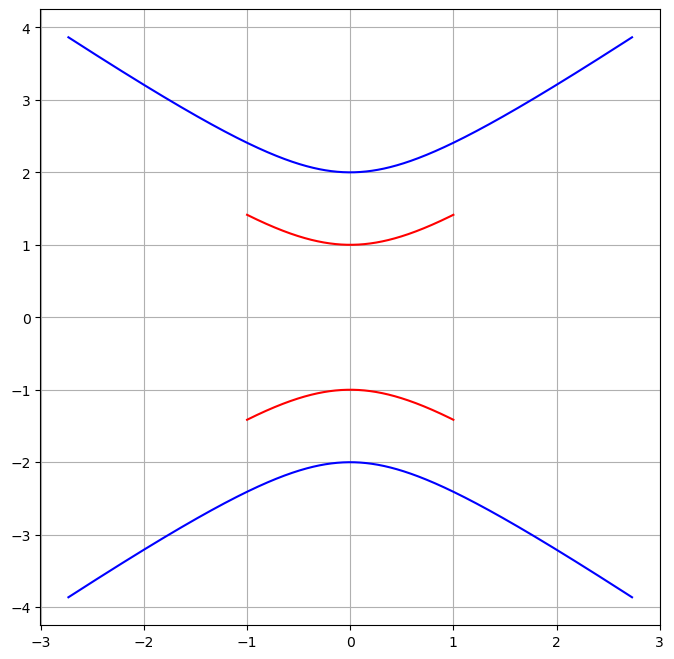

In [82]:
x = np.linspace(-1, 1, 1000)
yup = np.sqrt(1 + x**2)
ydown = -yup

Tx, Tyup = TxTy(x, yup, distortion)
Tx, Tydown = TxTy(x, ydown, distortion)

plt.figure(figsize=(8,8))
plt.plot(x,yup, '-r')
plt.plot(x,ydown, '-r')
plt.plot(Tx, Tyup, '-b')
plt.plot(Tx, Tydown, '-b')

plt.grid()

/tmp/ipykernel_286568/3651329613.py:2: RuntimeWarning: invalid value encountered in sqrt
  y = np.sqrt(4*x)


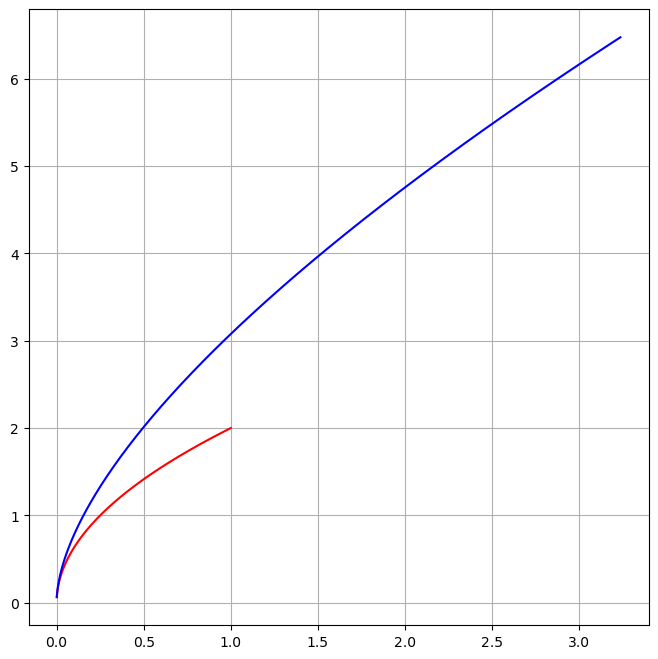

In [83]:
x = np.linspace(-1, 1, 1000)
y = np.sqrt(4*x)

Tx, Ty = TxTy(x, y, distortion)


plt.figure(figsize=(8,8))
plt.plot(x,y, '-r')
plt.plot(Tx, Ty, '-b')

plt.grid()

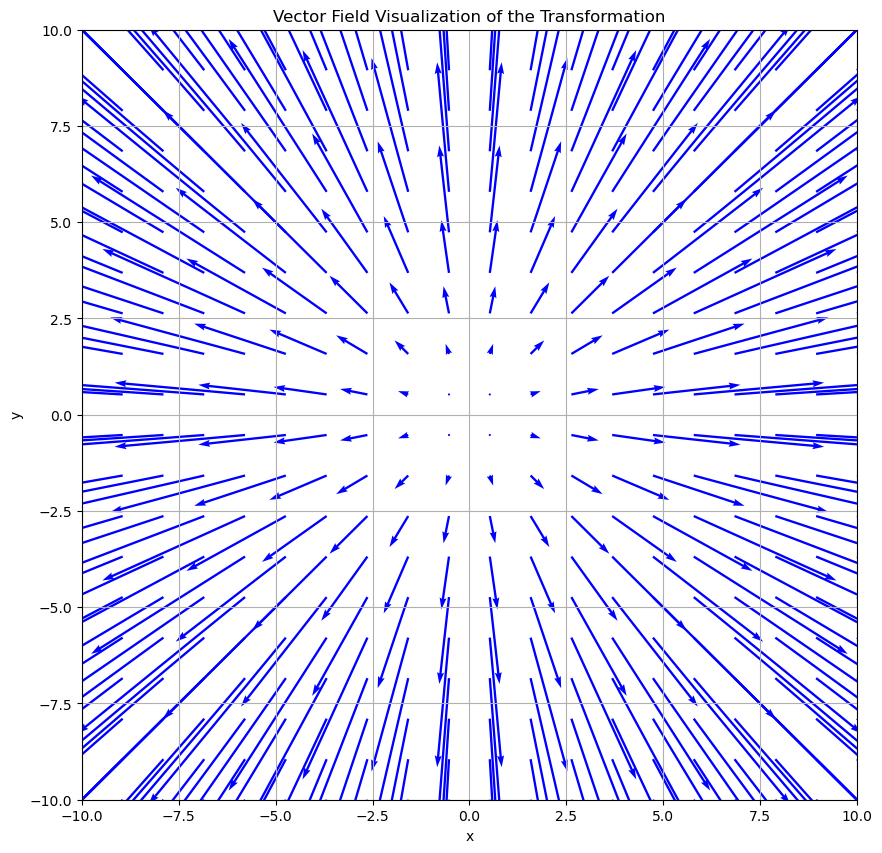

In [84]:
# 좌표평면의 점들 생성
x = np.linspace(-10, 10, 20)
y = np.linspace(-10, 10, 20)

X, Y = np.meshgrid(x, y)

# 변환 적용
U, V = np.vectorize(TxTy)(X, Y, 0.1)
U -= X
V -= Y

# 벡터장 그리기
plt.figure(figsize=(10, 10))
plt.quiver(X, Y, U, V, angles='xy', scale_units='xy', scale=1, color='blue')
plt.xlim(-10, 10)
plt.ylim(-10, 10)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Vector Field Visualization of the Transformation')
plt.grid(True)
plt.show()

In [85]:
source_tensor = get_image_tensor(source_image)
source_tensor.shape

torch.Size([1, 3, 1024, 2048])

In [86]:
N, C, H, W = source_tensor.shape
print(N, C, H, W)

1 3 1024 2048


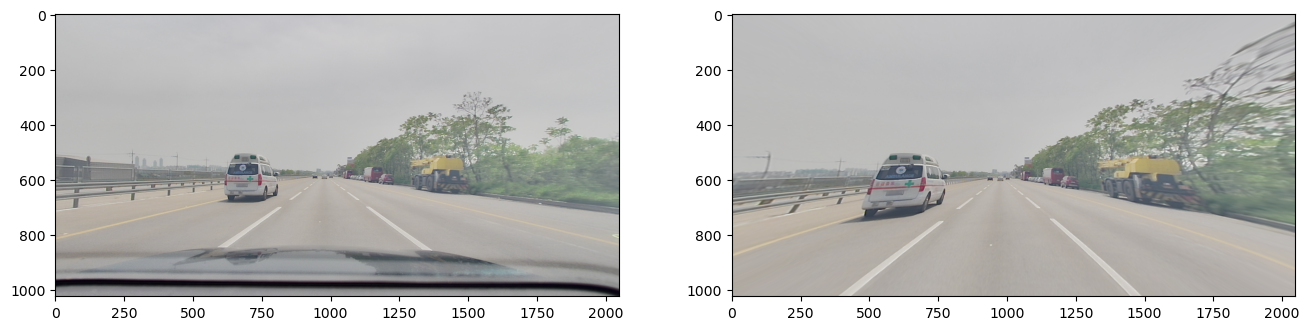

In [95]:
fish_grid = fisheye_grid(H, W, torch.tensor([0.0, 0.0]), 0.4)
fisheye_output = F.grid_sample(source_tensor, fish_grid, align_corners=True)
plot(source_image, fisheye_output)

In [96]:
fisheye_output.shape

torch.Size([1, 3, 1024, 2048])

In [97]:
fisheye_output = fisheye_output[0].numpy()
fisheye_output = np.moveaxis(fisheye_output, 0, -1)

In [98]:
fisheye_output.shape

(1024, 2048, 3)

In [7]:
import numpy as np
import cv2

def fisheye_transform(image, fov_degree=200):
    # Get the shape of the image
    h, w, _ = image.shape
    
    # Calculate the focal length
    f = 0.5 * w / np.tan(0.5 * np.radians(fov_degree))
    
    # Define the new image
    new_image = np.zeros_like(image)
    
    # Center of the image
    cx, cy = w // 2, h // 2
    
    for x in range(w):
        for y in range(h):
            # Convert (x, y) to polar coordinates with respect to center
            dx, dy = x - cx, y - cy
            r = np.sqrt(dx**2 + dy**2)
            theta = np.arctan2(dy, dx)
            
            # Map to fisheye space
            r_fisheye = f * np.tan(r / f)
            
            # Convert back to Cartesian coordinates
            x_fisheye = int(cx + r_fisheye * np.cos(theta))
            y_fisheye = int(cy + r_fisheye * np.sin(theta))
            
            # Check bounds and assign pixel value
            if 0 <= x_fisheye < w and 0 <= y_fisheye < h:
                new_image[y, x] = image[y_fisheye, x_fisheye]
                
    return new_image

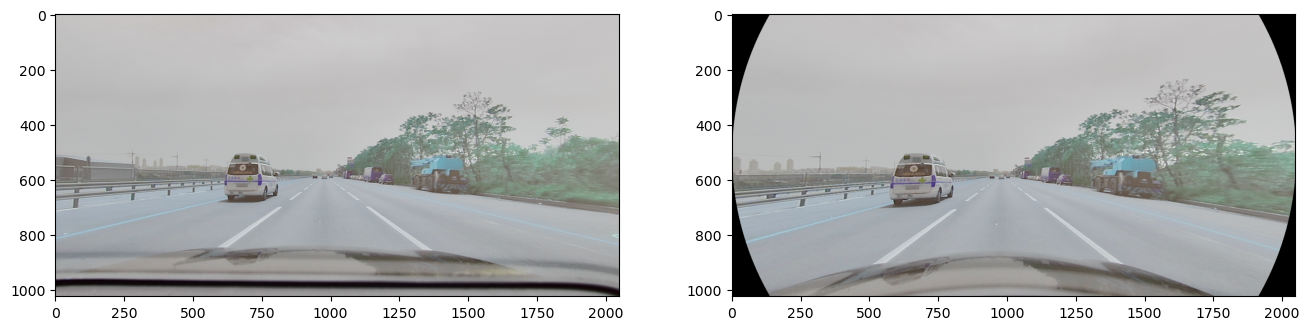

In [73]:
def fisheye_circular_transform(image, fov_degree=200, focal_scale = 4.5):
    # Get the shape of the image
    h, w, _ = image.shape
    
    # Calculate the focal length using the given FOV
    f = w / (2 * np.tan(0.5 * np.radians(fov_degree)))
    f_scaled = f * focal_scale
    
    # Define the new image
    new_image = np.zeros_like(image)
    
    # Center of the image
    cx, cy = w // 2, h // 2
    
    # Maximum allowable radius (image should fit within this)
    max_radius = cx
    
    for x in range(w):
        for y in range(h):
            # Convert (x, y) to polar coordinates with respect to center
            dx, dy = x - cx, y - cy
            r = np.sqrt(dx**2 + dy**2)
            theta = np.arctan2(dy, dx)
            
            # Check if within allowable circle
            if r <= max_radius:
                r_fisheye = f_scaled * np.arctan(r / f_scaled)
                
                # Convert back to Cartesian coordinates
                x_fisheye = int(cx + r_fisheye * np.cos(theta))
                y_fisheye = int(cy + r_fisheye * np.sin(theta))
                
                # Check bounds and assign pixel value
                if 0 <= x_fisheye < w and 0 <= y_fisheye < h:
                    new_image[y, x] = image[y_fisheye, x_fisheye]
                
    return new_image

# Test the circular fisheye transform
circular_transformed_image = fisheye_circular_transform(test_image)

fig, ax = plt.subplots(1,2, figsize = (16,8))
ax[0].imshow(test_image)
ax[1].imshow(circular_transformed_image)

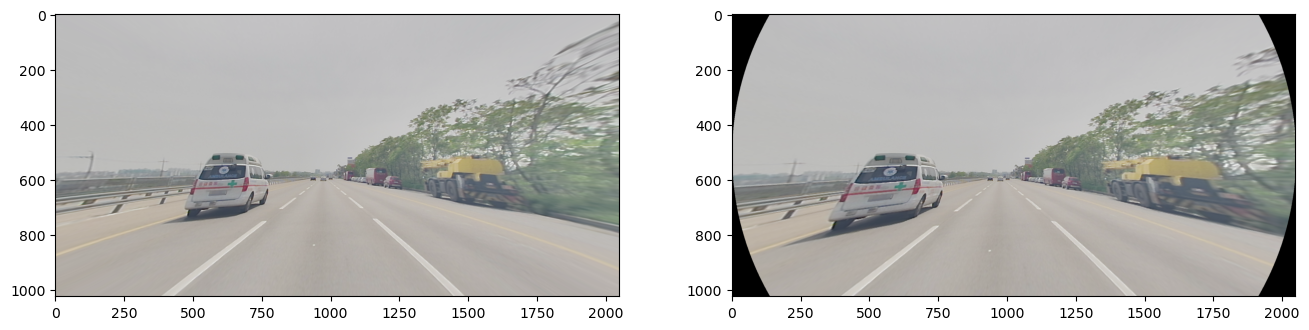

In [99]:
fig, ax = plt.subplots(1,2, figsize = (16,8))
ax[0].imshow(fisheye_output)
ax[1].imshow(fisheye_circular_transform(fisheye_output))

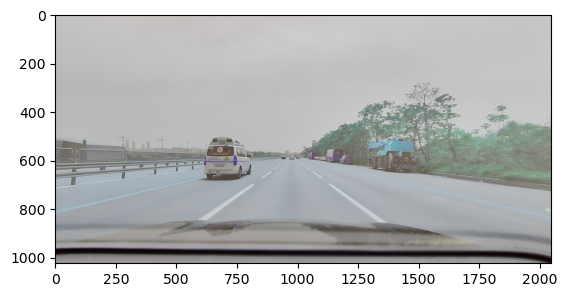

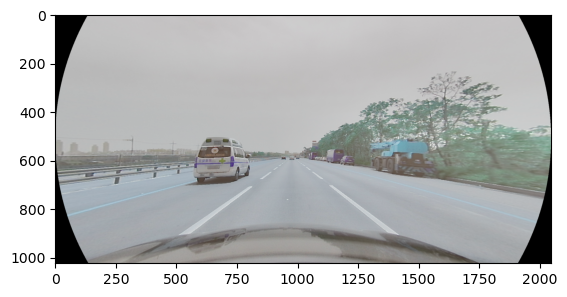

In [61]:
plt.imshow(circular_transformed_image)

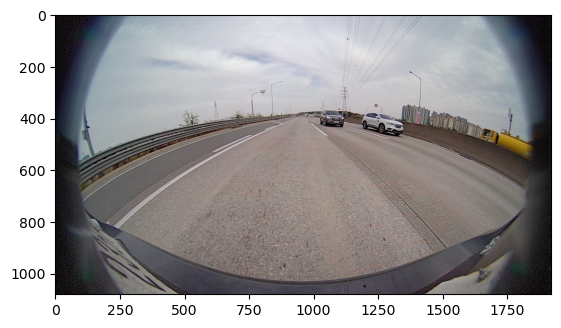

In [33]:
plt.imshow(target_image)

In [65]:
def fisheye_stereographic_transform(image, fov_degree=200, focal_scale = 4.5):
    # Get the shape of the image
    h, w, _ = image.shape
    
    # Calculate the focal length using the given FOV
    f = w / (2 * np.tan(0.5 * np.radians(fov_degree)))
    f_scaled = f * focal_scale
    
    # Define the new image
    new_image = np.zeros_like(image)
    
    # Center of the image
    cx, cy = w // 2, h // 2
    
    # Maximum allowable radius (image should fit within this)
    max_radius = cx
    
    for x in range(w):
        for y in range(h):
            # Convert (x, y) to polar coordinates with respect to center
            dx, dy = x - cx, y - cy
            r = np.sqrt(dx**2 + dy**2)
            theta = np.arctan2(dy, dx)
            
            # Check if within allowable circle
            if r <= max_radius:
                r_fisheye = 2 * f_scaled * np.tan(theta/2)
                
                # Convert back to Cartesian coordinates
                x_fisheye = int(cx + r_fisheye * np.cos(theta))
                y_fisheye = int(cy + r_fisheye * np.sin(theta))
                
                # Check bounds and assign pixel value
                if 0 <= x_fisheye < w and 0 <= y_fisheye < h:
                    new_image[y, x] = image[y_fisheye, x_fisheye]
                
    return new_image

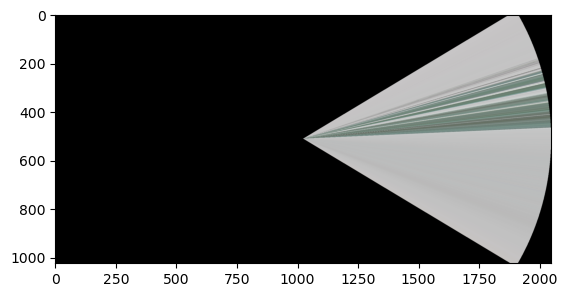

In [67]:
stereographic_transformed_image = fisheye_stereographic_transform(test_image, focal_scale = 10)
plt.imshow(stereographic_transformed_image)

In [31]:

get_image_tensor(target_image).shape

torch.Size([1, 3, 1080, 1920])

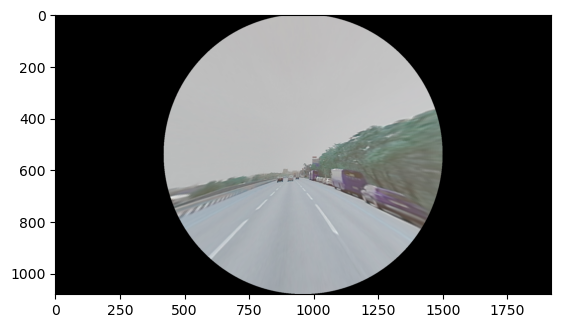

In [35]:
def fisheye_circular_transform_resized_adjusted(image, output_size=(1920, 1080), fov_degree=200, focal_scale=1.0):
    # Resize the input image to the desired output size
    resized_image = cv2.resize(image, output_size)
    
    # Calculate the focal length using the given FOV
    w, h = output_size
    f = (w / (2 * np.tan(0.5 * np.radians(fov_degree)))) * focal_scale
    
    # Apply circular fisheye transform with adjusted focal length
    transformed_image = fisheye_circular_transform(resized_image, fov_degree)
    
    return transformed_image

# Test the adjusted circular fisheye transform with a smaller focal length
circular_resized_adjusted_image = fisheye_circular_transform_resized_adjusted(test_image, focal_scale=1.4)

plt.imshow(circular_resized_adjusted_image)


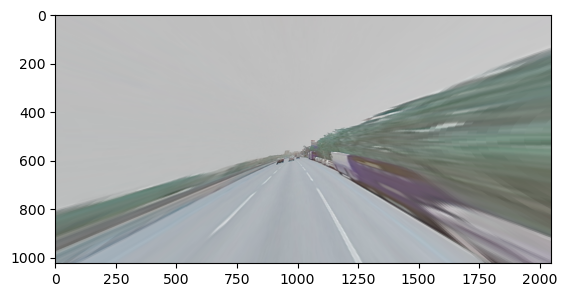

In [38]:
def fisheye_circular_transform_expanded(image, fov_degree=200, focal_scale=0.5):
    # Get the shape of the image
    h, w, _ = image.shape
    
    # Calculate the focal length using the given FOV
    f = (w / (2 * np.tan(0.5 * np.radians(fov_degree)))) * focal_scale
    
    # Define the new image
    new_image = np.zeros_like(image)
    
    # Center of the image
    cx, cy = w // 2, h // 2
    
    for x in range(w):
        for y in range(h):
            # Convert (x, y) to polar coordinates with respect to center
            dx, dy = x - cx, y - cy
            r = np.sqrt(dx**2 + dy**2)
            theta = np.arctan2(dy, dx)
            
            # Enhanced fisheye effect by adjusting r
            r_enhanced = r * (1.2)  # magnify the radius
            
            # Adjusted fisheye model
            r_fisheye = f * np.arctan(r_enhanced / f)
            
            # Convert back to Cartesian coordinates
            x_fisheye = int(cx + r_fisheye * np.cos(theta))
            y_fisheye = int(cy + r_fisheye * np.sin(theta))
            
            # Check bounds and assign pixel value
            if 0 <= x_fisheye < w and 0 <= y_fisheye < h:
                new_image[y, x] = image[y_fisheye, x_fisheye]
                
    return new_image

# Test the expanded circular fisheye transform
circular_expanded_image = fisheye_circular_transform_expanded(test_image, focal_scale=0.7)

plt.imshow(circular_expanded_image)
